In [2]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import six
import time
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util
%matplotlib inline
os.getcwd()

'c:\\Users\\thana\\Desktop\\TheShit\\DurianSang\\Mobnet'

# Shape Detection Initial Function

In [3]:
def initShapeDetectionFunction():
    global image_x, image_y, path, file, top_category_index, top_detection_model, stick_category_index, stick_detection_model
    image_x = 640
    image_y = 360

    path = {
    'topcam_folder':os.path.join('dataset', 'data3', 'topcam'),
    'sidecam_folder':os.path.join('dataset', 'data3', 'side'),
    'stickcam_folder':os.path.join('dataset', 'data3', 'stick'),
    'top_checkpoint_path':os.path.join('Model', 'my_ssd_mobnet4'),
    'stick_checkpoint_path':os.path.join('Model', 'my_stick_ssd_mobnet2')
    }

    file = {
    'topcam_removeBG_model':os.path.join('Model', 'RemoveBottomBackground2.h5'),
    'sidecam_removeBG_model':os.path.join('Model', 'RemoveBackgroundVer9.h5'),
    'top_pipeline_config':os.path.join(path['top_checkpoint_path'], 'pipeline.config'),
    'stick_pipeline_config':os.path.join(path['stick_checkpoint_path'], 'pipeline.config'),
    'top_label_map':os.path.join('annotations', 'label_map.pbtxt'),
    'stick_label_map':os.path.join('annotations', 'stick_label_map2.pbtxt')
    }

    top_category_index = label_map_util.create_category_index_from_labelmap(file['top_label_map'])
    top_configs = config_util.get_configs_from_pipeline_file(file['top_pipeline_config'])
    top_detection_model = model_builder.build(model_config = top_configs['model'], is_training=False)
    top_ckpt = tf.compat.v2.train.Checkpoint(model = top_detection_model)
    top_ckpt.restore(os.path.join(path['top_checkpoint_path'], 'ckpt-201')).expect_partial()

    stick_category_index = label_map_util.create_category_index_from_labelmap(file['stick_label_map'])
    stick_configs = config_util.get_configs_from_pipeline_file(file['stick_pipeline_config'])
    stick_detection_model = model_builder.build(model_config = stick_configs['model'], is_training=False)
    stick_ckpt = tf.compat.v2.train.Checkpoint(model = stick_detection_model)
    stick_ckpt.restore(os.path.join(path['stick_checkpoint_path'], 'ckpt-201')).expect_partial()

@tf.function
def bottom_detect_fn(image):
    image, shapes = top_detection_model.preprocess(image)
    prediction_dict = top_detection_model.predict(image, shapes)
    detections = top_detection_model.postprocess(prediction_dict, shapes)
    return detections

@tf.function
def stick_detect_fn(image):
    image, shapes = stick_detection_model.preprocess(image)
    prediction_dict = stick_detection_model.predict(image, shapes)
    detections = stick_detection_model.postprocess(prediction_dict, shapes)
    return detections

def getCenterFromModel(detections, hight, width):
    ##### input detections['detection_boxes'][max score index]
    ##### output (x,y) 
    ymin = np.array(detections[0] * hight)
    xmin = np.array(detections[1] * width)
    ymax = np.array(detections[2] * hight)
    xmax = np.array(detections[3] * width)
    center_x = ((xmax - xmin)/2) + xmin
    center_y = ((ymax - ymin)/2) + ymin
    return center_x, center_y

def rotatePointZaxis(angle, point):
    ##### Rotation Matrix #####
    theta = np.radians(angle)
    [cos, sin] = np.cos(theta), np.sin(theta)
    [x_new, y_new, z_new,  _] = [((point[0]*cos) - (point[1]*sin)), ((point[2]*sin) + (point[1]*cos)), point[2], 1]
    point_new = [x_new, y_new, z_new]
    
    return point_new

def rotatePointXaxis(angle, point):
    ##### Rotation Matrix #####|
    theta = np.radians(angle)
    [cos, sin] = np.cos(theta), np.sin(theta)
    [x_new, y_new, z_new,  _] = [point[0], ((point[1]*cos) - (point[2]*sin)), ((point[1]*sin) + (point[2]*cos)), 1]
    point_new = [x_new, y_new, z_new]
    
    return point_new

def transaltePointXaxis(x, point):
    [x_new, y_new, z_new, _] = [point[0] + x, point[1], point[2], 1]
    point_new = [x_new, y_new, z_new]

    return point_new

def translatePointZaxis(z, point):
    [x_new, y_new, z_new, _] = [point[0], point[1], point[2] + z, 1]
    point_new = [x_new, y_new, z_new]

    return point_new

def scaleMatrix(scale, point):
    [x_new, y_new, z_new, _] = [point[0]*scale[0], point[1]*scale[1], point[2]*scale[2], 1]
    point_new = [x_new, y_new, z_new]

    return point_new



# Top Camera Function

In [4]:
def Topcam_RemoveBG(image):
    ##### return image with INPUT shape #####
    src = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    [hight, width, _] = src.shape
    src_resize = cv.resize(src, (image_x, image_y))
    src_resize = src_resize / 255.0
    
    model = tf.keras.models.load_model(file['topcam_removeBG_model'])
    predict = model.predict(np.array([src_resize]))
    predict = predict.reshape(image_y, image_x)
    
    ret, predict = cv.threshold(predict, 0.2, 1.0, cv.THRESH_BINARY)
    
    predict = cv.resize(predict, (width, hight)).reshape(hight, width, 1)
    res = np.multiply(src/255., np.repeat(predict, 3, axis = 2))
    res = res * 255
    output = res.astype(np.uint8)

    return output

def Bottom_Detection(image):
    ##### return image with Input shape (360x640)#####
    src = cv.resize(image, (image_x, image_y))
    [hight,width,_] = src.shape
    image_np = np.array(src).astype(np.uint8)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = bottom_detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy() for key, value in detections.items()}
    detections['num_detections'] = num_detections
    
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)
    
    label_id_offset = 1
    image_np_with_detections = image_np.copy()
    
    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes'] + label_id_offset,
                detections['detection_scores'],
                top_category_index,
                use_normalized_coordinates = True,
                max_boxes_to_draw = 2,
                min_score_thresh = (0.18),
                agnostic_mode = False)
    

    if(detections['detection_scores'][0] >= 0.18):
        detected = True
    else:
        detected = False
    
    bottom_detect_point = getCenterFromModel(detections['detection_boxes'][0], hight, width)
    
    ##### Distance #####
    #x_distance = bottom_pixel[0] - 316 
    #y_distance = bottom_pixel[1] - 157
    #distance = [x_distance, y_distance]
    #
    ###### X Axis Line #####
    #cv.line(image_np_with_detections, (316, 0), (316, 360), (0, 255, 0), 2)
    #
    ###### Y Axis Line #####
    #cv.line(image_np_with_detections, (0, 157), (640, 157), (255, 0, 0), 2)
    #
    ###### Connect Line #####
    #cv.line(image_np_with_detections, (316, 157) , (int(center_x), int(center_y)), (0, 0, 255), 2)
    
    return image_np_with_detections, bottom_detect_point, detected

# Side Camera Function

In [5]:
def Sidecam_RemoveBG(image):
    ##### return image with (360x640) shape #####
    src = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    [hight, width, _] = src.shape
    src_resize = cv.resize(src, (256, 144))
    src_resize = src_resize/255.0
    
    model = tf.keras.models.load_model(file['sidecam_removeBG_model'])
    predict = model.predict(np.array([src_resize]))
    predict = predict.reshape(144, 256)
    
    ret, predict = cv.threshold(predict, 0.59, 1.0, cv.THRESH_BINARY)
    predict[predict != 0] = 1
    predict = cv.resize(predict, (width, hight)).reshape(hight, width, 1)
    #plt.imshow(predict, cmap = 'gray')
    #plt.show()
    res = np.multiply(src/255., np.repeat(predict, 3, axis = 2))
    res = res * 255
    output = res.astype(np.uint8)
    output = cv.resize(output, (image_x, image_y))
    
    return output

def getMaxAreaContour(image):
    ##### return max area contour #####
    image = image.astype('uint8')
    if(len(image.shape) != 3):
        src_gray = image
    else:
        src_gray = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
        
    src_gray = cv.medianBlur(src_gray, 15)
    
    _, thresh = cv.threshold(src_gray, 30, 255, cv.THRESH_BINARY)
    contours , hierarchy = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
    max_area_countour = max(contours, key = cv.contourArea)
    
    return max_area_countour

def Point_Cam_Frame(deg, x_top, y_top):
    ##### Rotation Matrix #####
    theta = np.radians(deg)
    [cos, sin] = np.cos(theta), np.sin(theta)
    [x_cam, y_cam, _] = [((x_top*cos) - (y_top*sin)), ((x_top*sin) + (y_top*cos)), 1]
    bottom_point = [x_cam, y_cam]
    
    return bottom_point

def getPercentSymmetric(image, deg, rot_point):
    rotate_matrix = cv.getRotationMatrix2D(center = (rot_point[0], rot_point[1]), angle= int(deg), scale=1)
    rotated_image = cv.warpAffine(src = image, M = rotate_matrix, dsize = (image.shape[1], image.shape[0]))

    c = getMaxAreaContour(rotated_image)
    x, y ,w, h = cv.boundingRect(c)
    crop_rotate_image = rotated_image[0:(rot_point[1]*2), x:x+w]

    mirror = np.flipud(crop_rotate_image)

    intersec_image = cv.bitwise_and(cv.cvtColor(crop_rotate_image, cv.COLOR_RGB2GRAY), cv.cvtColor(mirror, cv.COLOR_RGB2GRAY))
    intersec_image[intersec_image != 0] = 255

    union_image = cv.bitwise_or(cv.cvtColor(crop_rotate_image, cv.COLOR_RGB2GRAY), cv.cvtColor(mirror, cv.COLOR_RGB2GRAY))
    union_image[union_image != 0] = 255

    intersec_area = cv.contourArea(getMaxAreaContour(intersec_image))
    union_area = cv.contourArea(getMaxAreaContour(union_image))

    cv.drawContours(crop_rotate_image, getMaxAreaContour(intersec_image), -1, (255, 0, 0), 2)

    inersec_percentage = (intersec_area / union_area)*100
    print('Intersection Percentage: ' + str(round(inersec_percentage)) + '%')
    ##### X Axis On Side Camera #####
    cv.line(rotated_image, (rot_point[0], 0), (rot_point[0], 360), (255, 0, 0), 2)
    ##### Y Axis On Side Camera #####
    cv.line(rotated_image, (0, rot_point[1]), (640, rot_point[1]), (0, 0, 255), 2)
    
    plt.imshow(cv.hconcat([cv.rotate(crop_rotate_image, cv.ROTATE_90_COUNTERCLOCKWISE), cv.rotate(mirror, cv.ROTATE_90_COUNTERCLOCKWISE)]))
    plt.show()
    plt.imshow(cv.hconcat([cv.rotate(intersec_image, cv.ROTATE_90_COUNTERCLOCKWISE), cv.rotate(union_image, cv.ROTATE_90_COUNTERCLOCKWISE)]), cmap = 'gray')
    plt.show()
    
    

# Stick Camera Function

In [6]:
def detectLeftStick(image):
    ##### return image with (320x320) shape #####
    ##### list index 0 means base of the stick
    ##### list index 1 means end of the stick
    ##### pixel index 0 means x coordinate
    ##### pixel index 1 means y coordinate
    src = cv.resize(image, (640, 360))
    center_x = 435
    center_y = 180
    src = src[(center_y - center_y):(center_y + center_y), (center_x - center_y):(center_x + center_y)]
    src = cv.resize(src, (320, 320))
    [hight,width,_] = src.shape
    image_np = np.array(src).astype(np.uint8)
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    
    detections = stick_detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy() for key, value in detections.items()}
    detections['num_detections'] = num_detections
    label_id_offset = 1
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64) + label_id_offset
    base_index = np.where(detections['detection_classes'] == 1)[0][0]
    end_index = np.where(detections['detection_classes'] == 2)[0][0]
    image_np_with_detections = image_np.copy()
                
    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes'],
                detections['detection_scores'],
                stick_category_index,
                use_normalized_coordinates = True,
                max_boxes_to_draw = 2,
                min_score_thresh = (0.2),
                agnostic_mode = False)
    
    if(detections['detection_scores'][base_index] >= 0.2):
        base_detected = True
    else:
        base_detected = False
    
    if(detections['detection_scores'][end_index] >= 0.2):
        end_detected = True
    else:
        end_detected = False
    
    detected = [base_detected, end_detected]

    ##### Point on (320x320) frame #####
    base_point = getCenterFromModel(detections['detection_boxes'][base_index], hight, width)
    end_point = getCenterFromModel(detections['detection_boxes'][end_index], hight, width)

    ##### Scale to 360x640 frame include offset #####
    scale_base_point = [(base_point[0]*1.125) + (center_x - center_y), (base_point[1]*1.125), 0]
    scale_end_point = [(end_point[0]*1.125) + (center_x - center_y), (end_point[1]*1.125), 0]
    
    return image_np_with_detections, scale_base_point, scale_end_point, detected

def detectRightStick(image):
    ##### return image with (320x320) shape #####
    ##### list index 0 means base of the stick
    ##### list index 1 means end of the stick
    ##### pixel index 0 means x coordinate
    ##### pixel index 1 means y coordinate
    src = cv.resize(image, (640, 360))
    center_x = 353
    center_y = 180
    src = src[(center_y - center_y):(center_y + center_y), (center_x - center_y):(center_x + center_y)]
    src = cv.resize(src, (320, 320))
    [hight,width,_] = src.shape
    image_np = np.array(src).astype(np.uint8)
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    
    detections = stick_detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy() for key, value in detections.items()}
    detections['num_detections'] = num_detections
    label_id_offset = 1
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64) + label_id_offset
    base_index = np.where(detections['detection_classes'] == 1)[0][0]
    end_index = np.where(detections['detection_classes'] == 2)[0][0]
    image_np_with_detections = image_np.copy()
                
    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes'],
                detections['detection_scores'],
                stick_category_index,
                use_normalized_coordinates = True,
                max_boxes_to_draw = 2,
                min_score_thresh = (0.2),
                agnostic_mode = False)
    
    if(detections['detection_scores'][base_index] >= 0.2):
        base_detected = True
    else:
        base_detected = False
    
    if(detections['detection_scores'][end_index] >= 0.2):
        end_detected = True
    else:
        end_detected = False
    
    detected = [base_detected, end_detected]

    ##### Point on (320x320) frame #####
    base_point = getCenterFromModel(detections['detection_boxes'][base_index], hight, width)
    end_point = getCenterFromModel(detections['detection_boxes'][end_index], hight, width)

    ##### Scale to 360x640 frame include offset #####
    scale_base_point = [(base_point[0]*1.125) + (center_x - center_y), (base_point[1]*1.125), 0]
    scale_end_point = [(end_point[0]*1.125) + (center_x - center_y), (end_point[1]*1.125), 0]
    
    return image_np_with_detections, scale_base_point, scale_end_point, detected

def getLengthAndAngle(base_point, end_point):
    base_disparity = base_point[0] - base_point[1]
    end_disparity = end_point[0] - end_point[1]

    base_dept = (38 * 930) / (base_disparity * 2)
    end_dept = (38 * 930) / (end_disparity * 2)

    base_x = (base_dept * ((base_point[0]*2) - 640)) / 930
    end_x = (end_dept * ((end_point[0]*2) - 640)) / 930

    stick_angle = math.atan((base_dept - end_dept)/(base_x - end_x)) * (180/math.pi)
    stick_length = math.sqrt( ((base_dept - end_dept)**2) + ((base_x - end_x)**2) )
    
    return stick_length, stick_angle

# All Code In Function

In [7]:
def detectShape(side_img, imgL, imgR):
    imgL_detection, lbp, lep, left_detected = detectLeftStick(imgL)
    imgR_detection, rbp, rep, right_detected = detectRightStick(imgR)
    stick_length, stick_angle = getLengthAndAngle([lbp[0], rbp[0]], [lep[0], rep[0]])
    trans_bts = transaltePointXaxis(640, lbp)
    rot_bts = rotatePointXaxis(90, trans_bts)
    point_bts = rotatePointZaxis(45, rot_bts)
    point_bts = scaleMatrix(0.7, point_bts)
    if(left_detected and right_detected):
        sidecam_removeBG = Sidecam_RemoveBG(side_img)
        c = getMaxAreaContour(sidecam_removeBG)
        end_index = (np.where(c[:,0,1] == round(point_bts[1])))[0][-1]
        heightest_point = c[end_index][0]
        min_index = (np.where(c[:,0,0] == min(c[:,0,0])))[0][0]
        lowest_point = c[min_index][0]
        rot_point = [round(lowest_point[0]), round(point_bts[1])]
        durian_angle = (math.atan2((int(point_bts[1] - rot_point[1])), (int(heightest_point[0] - rot_point[0])))) * (180/math.pi)
        getPercentSymmetric(sidecam_removeBG, durian_angle, rot_point)
    else:
        print('CANNOT FIND STICK OF DURAIN')


# Test Function

1/1 [==============================] - 0s 163ms/step


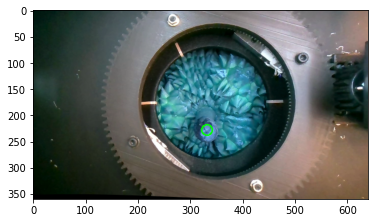

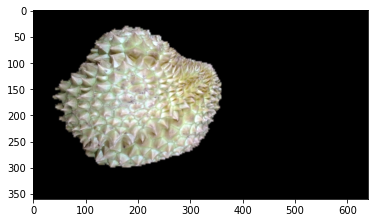

In [22]:
initShapeDetectionFunction()
sidecam_pic_name = next(os.walk(path['sidecam_folder']))[2]
imgL_pic_name = next(os.walk(os.path.join(path['stickcam_folder'], 'frame1')))[2]
imgR_pic_name = next(os.walk(os.path.join(path['stickcam_folder'], 'frame2')))[2]
cv_file = cv.FileStorage()
cv_file.open('stereoMap.xml', cv.FileStorage_READ)

stereoMapL_x = cv_file.getNode('stereoMapL_x').mat()
stereoMapL_y = cv_file.getNode('stereoMapL_y').mat()
stereoMapR_x = cv_file.getNode('stereoMapR_x').mat()
stereoMapR_y = cv_file.getNode('stereoMapR_y').mat()

imgL = cv.imread(os.path.join(path['stickcam_folder'], 'frame1', imgL_pic_name[0]))
imgL = cv.remap(imgL, stereoMapL_x, stereoMapL_y, cv.INTER_LANCZOS4, cv.BORDER_CONSTANT, 0)

imgR = cv.imread(os.path.join(path['stickcam_folder'], 'frame2', imgR_pic_name[0]))
imgR = cv.remap(imgR, stereoMapR_x, stereoMapR_y, cv.INTER_LANCZOS4, cv.BORDER_CONSTANT, 0)

side_img = cv.imread(os.path.join(path['sidecam_folder'], sidecam_pic_name[0]))

imgL_detection, lbp, lep, left_detected = detectLeftStick(imgL)
imgR_detection, rbp, rep, right_detected = detectRightStick(imgR)
stick_length, stick_angle = getLengthAndAngle([lbp[0], rbp[0]], [lep[0], rep[0]])

trans_bts = transaltePointXaxis(640, rbp)
rot_bts = rotatePointXaxis(90, trans_bts)
point_bts = rotatePointZaxis(45, rot_bts)
point_bts = scaleMatrix(([0.7] * 3), point_bts)

if(left_detected[0] and right_detected[0] and left_detected[1] and right_detected[1]):
    sidecam_removeBG = Sidecam_RemoveBG(side_img)
    c = getMaxAreaContour(sidecam_removeBG)
    end_index = (np.where(c[:,0,1] == round(point_bts[1])))[0][-1]
    heightest_point = c[end_index][0]
    min_index = (np.where(c[:,0,0] == min(c[:,0,0])))[0][0]
    lowest_point = c[min_index][0]
    rot_point = [round(lowest_point[0]), round(point_bts[1])]
    #durian_angle = (math.atan2((int(point_bts[1] - rot_point[1])), (int(heightest_point[0] - rot_point[0])))) * (180/math.pi)
    #getPercentSymmetric(sidecam_removeBG, durian_angle, rot_point)

    plt.imshow(imgR)
    plt.show()

    plt.imshow(sidecam_removeBG)
    plt.show()
else:
    print('CANNOT FIND STICK OF DURAIN')

# RUN ALL

In [ ]:
initShapeDetectionFunction()
topcam_folder = next(os.walk(path['topcam_folder']))[1]
for i in topcam_folder:
    topcam_folder_path = os.path.join(path['topcam_folder'], str(i))
    sidecam_folder_path = os.path.join(path['sidecam_folder'], str(i))
    stickcam_folder_path = os.path.join(path['stickcam_folder'], str(i))

    topcam_pic_name = next(os.walk(topcam_folder_path))[2]
    sidecam_pic_name = next(os.walk(sidecam_folder_path))[2]
    stickcam_pic_name = next(os.walk(stickcam_folder_path))[2]


    for j in range(len(sidecam_pic_name)):
        topcam_pic_path = os.path.join(topcam_folder_path, topcam_pic_name[j])
        topcam_image = cv.imread(topcam_pic_path, cv.IMREAD_COLOR)
        sidecam_pic_path = os.path.join(sidecam_folder_path, sidecam_pic_name[j])
        sidecam_image = cv.imread(sidecam_pic_path, cv.IMREAD_COLOR)
        stickcam_pic_path = os.path.join(stickcam_folder_path, stickcam_pic_name[j])
        stickcam_image = cv.imread(stickcam_pic_path, cv.IMREAD_COLOR)
        #ref_path = os.path.join('Ref', '2022-07-14_17-14-27.jpg')
        #ref_image = cv.imread(ref_path, cv.IMREAD_COLOR)
        #ref_image = cv.resize(ref_image, (image_x, image_y))
        
        ##### Stick Camera Part #####
        stick_detection_image, base_on_top_point, end_point, detected = detectLeftStick(stickcam_image)
        stick_point = Point_Cam_Frame(45, base_on_top_point[0], base_on_top_point[1])
        stick_y_distance = (math.sqrt((stick_point[0] - base_on_top_point[0])**2 + (stick_point[1] - base_on_top_point[1])**2)) * 0.7
        ##### Top Camera Part #####
        topcam_removeBG = Topcam_RemoveBG(topcam_image)
        buttom_detection, bottom_detect_point, bottom_detected = Bottom_Detection(topcam_removeBG)
        bottom_point = Point_Cam_Frame(45, bottom_detect_point[0], bottom_detect_point[1])
        y_distance = (math.sqrt((bottom_point[0] - base_on_top_point[0])**2 + (bottom_point[1] - base_on_top_point[1])**2)) * 0.7  
        
        ##### X Axis Line #####
        cv.line(buttom_detection, (round(base_on_top_point[0]), 0), (round(base_on_top_point[0]), 360), (0, 255, 0), 2)
        ##### Y Axis Line #####
        cv.line(buttom_detection, (0, round(base_on_top_point[1])), (640, round(base_on_top_point[1])), (255, 0, 0), 2)
        ##### Connect Line #####
        cv.line(buttom_detection, (round(base_on_top_point[0]), round(base_on_top_point[1])) , (round(bottom_detect_point[0]), round(bottom_detect_point[1])), (0, 0, 255), 2)
        ##### Draw Circle ######
        cv.circle(buttom_detection, (round(base_on_top_point[0]), round(base_on_top_point[1])), 10, (0, 255, 0), 2)
        plt.imshow(buttom_detection)
        plt.grid()
        plt.show()
        #print('base coordinate: (' + str(round(base_on_top_point[0])) + ', ' + str(round(base_on_top_point[1])) + ')')
        #print('bottom coordinate: (' + str(round(bottom_detect_point[0])) + ', ' + str(round(bottom_detect_point[1])) + ')')

        #x_distance = bottom_detect_point[0] - (base_on_top_point[0]) 
        #y_distance = bottom_detect_point[1] - (base_on_top_point[1])
        #distance = [x_distance, y_distance]
        #print('X distance: ' + str(round(x_distance)))
        #print('Y distance: ' + str(round(y_distance)))

        ##### Side Camera Part #####
        if(bottom_detected):
            sidecam_removeBG = Sidecam_RemoveBG(sidecam_image)
            c = getMaxAreaContour(sidecam_removeBG)
            end_index = (np.where(c[:,0,1] == round(y_distance)))[0][-1]
            end_point = c[end_index][0]
            #max_index = (np.where(c[:,0,0] == max(c[:,0,0])))[0][0]
            #heightest_point = c[max_index][0]
            min_index = (np.where(c[:,0,0] == min(c[:,0,0])))[0][0]
            lowest_point = c[min_index][0]
            #z_durian_height = heightest_point[0]
            rot_point = [round(lowest_point[0]), round(stick_y_distance)]
            durian_angle = (math.atan2((int(y_distance - rot_point[1])), (int(end_point[0] - rot_point[0])))) * (180/math.pi)
            
            getPercentSymmetric(sidecam_removeBG, durian_angle, rot_point)

            ##### X Axis On Side Camera #####
            cv.line(sidecam_removeBG, (rot_point[0], 0), (rot_point[0], 360), (0, 255, 0), 2)
            ##### Y Axis On Side Camera #####
            cv.line(sidecam_removeBG, (0, rot_point[1]), (640, rot_point[1]), (0, 0, 255), 2)
            ##### Orientation line #####
            cv.line(sidecam_removeBG, (rot_point[0], rot_point[1]), (int(end_point[0]), int(end_point[1])), (255, 255, 255), 2)

            plt.imshow(sidecam_removeBG)
            plt.grid()
            plt.show()

        else:
            print('CANNOT FIND BOTTOM OF THIS OBJECT')
        

# Random Scripts

In [ ]:
################################ RANDOM PICTURE #########################################################
topcam_folder = next(os.walk(path['topcam_folder']))[1]
sidecam_folder = next(os.walk(path['sidecam_folder']))[1]
random_folder_number = random.randint(0, (len(sidecam_folder)-1))
topcam_folder_path = os.path.join(path['topcam_folder'], topcam_folder[random_folder_number])
sidecam_folder_path = os.path.join(path['sidecam_folder'], sidecam_folder[random_folder_number])

topcam_pic_name = next(os.walk(topcam_folder_path))[2]
sidecam_pic_name = next(os.walk(sidecam_folder_path))[2]

########################################################################################################

for i in range(len(topcam_pic_name)):
    break